In [1]:
# PDF印刷用
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 1
pdf_base = 'pdf-00-'

def create_pdf(plt):
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

# 序章

## ライブラリ・コマンドの準備

In [12]:
# 必要ライブラリ・コマンドの導入
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
w = !apt install tree
print(w[-2])

tree is already the newest version (1.7.0-5).


In [3]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## 初期設定

In [4]:
# 初期設定

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

In [5]:
# デバイスの割り当て (8章)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
# 共通関数の読み込み (9章)

# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


In [ ]:
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


## 学習データ読み込み

In [7]:
# 学習用データの取り込み (12章)

# 学習用イメージのダウンロード
w = !wget https://github.com/makaishi2/pythonlibs/raw/main/images/dog_wolf.zip
print(w[-2])

# 学習用イメージの展開
w = !unzip dog_wolf.zip
print(w[-1])
 # ディレクトリ名の設定
data_dir = 'dog_wolf'

# ディレクトリ名設定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# 分類先クラス名設定
classes = ['dog', 'wolf']

# 解凍結果のツリー表示
!tree dog_wolf

2021-04-11 13:42:38 (115 MB/s) - ‘dog_wolf.zip’ saved [21493752/21493752]
  inflating: dog_wolf/train/wolf/wolf-09.png  
dog_wolf
├── test
│   ├── dog
│   │   ├── dog-21.png
│   │   ├── dog-22.png
│   │   ├── dog-23.png
│   │   ├── dog-24.png
│   │   └── dog-25.png
│   └── wolf
│       ├── wolf-21.png
│       ├── wolf-22.png
│       ├── wolf-23.png
│       ├── wolf-24.png
│       └── wolf-25.png
└── train
    ├── dog
    │   ├── dog-01.png
    │   ├── dog-02.png
    │   ├── dog-03.png
    │   ├── dog-04.png
    │   ├── dog-05.png
    │   ├── dog-06.png
    │   ├── dog-07.png
    │   ├── dog-08.png
    │   ├── dog-09.png
    │   ├── dog-10.png
    │   ├── dog-11.png
    │   ├── dog-12.png
    │   ├── dog-13.png
    │   ├── dog-14.png
    │   ├── dog-15.png
    │   ├── dog-16.png
    │   ├── dog-17.png
    │   ├── dog-18.png
    │   ├── dog-19.png
    │   └── dog-20.png
    └── wolf
        ├── wolf-01.png
        ├── wolf-02.png
        ├── wolf-03.png
        ├── wolf-04.png
        ├─

In [8]:
# 学習用データの準備 (8章、10章、12章)

# transformの定義
# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
])

# datasetの定義
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# dataloaderの定義
batch_size = 5
#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)
train_loader2 = DataLoader(train_data2, batch_size=40, shuffle=False)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)
test_loader2 = DataLoader(test_data, batch_size=10, shuffle=True)


## 学習データのイメージ表示

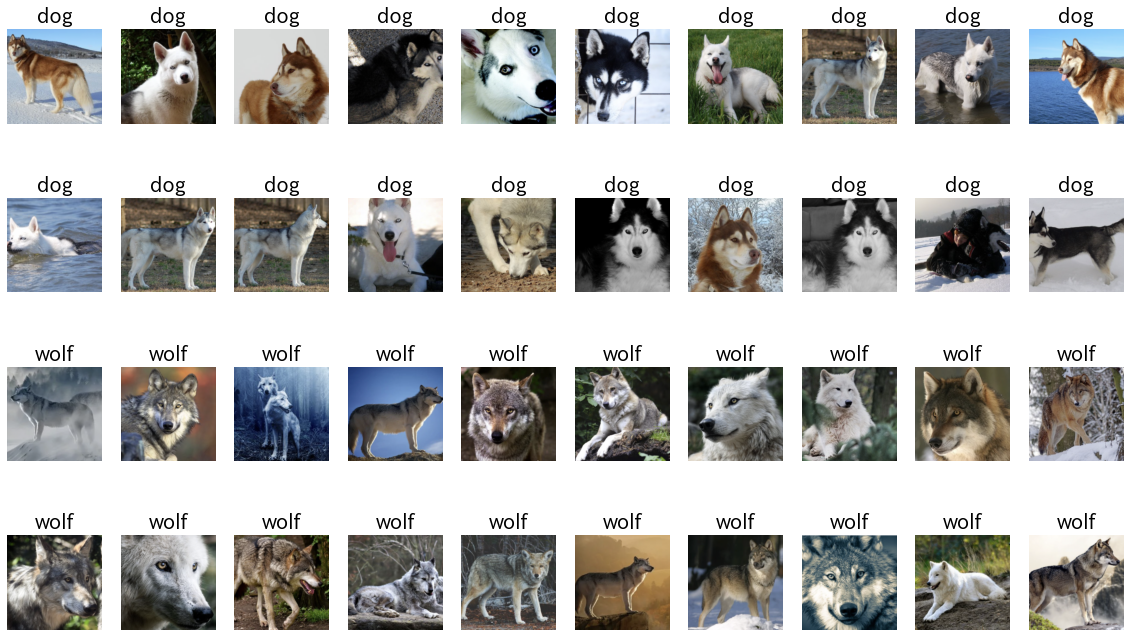

In [14]:
# 学習用データ(４0件)
show_images_labels(train_loader2, classes, None, device)

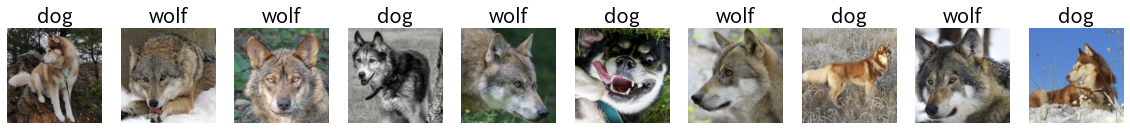

In [15]:
# 検証用データ(10件)
torch_seed()
show_images_labels(test_loader2, classes, None, device)

## モデル構築

In [16]:
# 学習済みモデルを利用したモデル構築 (11章)

# 乱数初期化
torch_seed()

# 学習済みモデルの読み込み
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 転移学習のためrequired_gradフラグをFalseにする
for param in net.parameters():
    param.requires_grad = False

# 最終ノードの出力を2に変更する
net.classifier[6] = nn.Linear(4096, 2)

# GPUの利用
net = net.to(device)

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義

# 学習率
lr = 0.001

# 重み修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))
# 学習の実行 (9章)

# 繰り返し回数
num_epochs = 3

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth



Epoch [1/3], loss: 0.13284 acc: 0.67500 val_loss: 0.08432, val_acc: 0.80000



Epoch [2/3], loss: 0.06217 acc: 0.90000 val_loss: 0.03575, val_acc: 1.00000



Epoch [3/3], loss: 0.04731 acc: 0.87500 val_loss: 0.03766, val_acc: 1.00000


## 結果確認

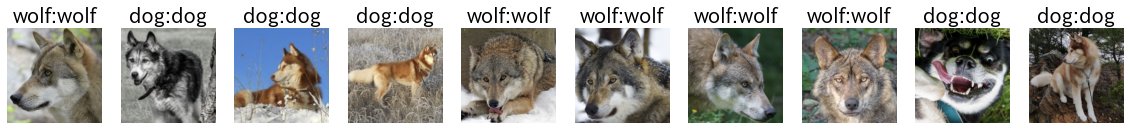

In [17]:
# 検証データを対象とした結果確認 (9章)
show_images_labels(test_loader2, classes, net, device)

## (参考)　共通関数の中身

In [ ]:

# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0
        from tqdm.notebook import tqdm

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 順伝搬計算
            outputs = net(inputs)

            # 誤差計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # 重み変更
            optimizer.step()

            #予測値算出
            predicted = torch.max(outputs, 1)[1]

            #正解件数算出
            train_acc += (predicted == labels).sum()

            # 訓練データに対する損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count
倍
        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 順伝搬計算
            outputs = net(inputs)

            # 誤差計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            #予測値算出
            predicted = torch.max(outputs, 1)[1]

            #正解件数算出
            val_acc += (predicted == labels).sum()

            # 検証データに対する損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history


In [ ]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # DataLoaderから最初の1セットを取得する
    for images, labels in loader:
        break
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測値の計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初の50個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        if net is not None:
          predicted_name = classes[predicted[i]]
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        else:
          ax.set_title(label_name, fontsize=20)
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        plt.imshow((img + 1)/2)
        ax.set_axis_off()
    plt.show()
